<a href="https://colab.research.google.com/github/anvishah1/ML-Lab/blob/main/ml_lab_ass_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
attributes = ["buying","maint","doors","persons","lug_boot","safety","target"]
df = pd.read_csv(url, header=None, names= attributes)
df.head()

,buying,maint,doors,persons,lug_boot,safety,target
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [ ]:
print(df.shape)
#class imbalance occurs
print(df["target"].value_counts())

(1728, 7)
target
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64


In [ ]:
#label encoding to convert the categorical data into numbers
encoder = LabelEncoder()
for clm in df.columns:
  df[clm] = encoder.fit_transform(df[clm])
df.head()

,buying,maint,doors,persons,lug_boot,safety,target
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2


In [ ]:
X=df.drop("target",axis=1)
Y=df["target"]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state =42, stratify = Y)

In [ ]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

#class distribution mainted:
print(Y_train.value_counts())
print(Y_test.value_counts())

(1382, 6)
(1382,)
(346, 6)
(346,)
target
2    968
0    307
1     55
3     52
Name: count, dtype: int64
target
2    242
0     77
1     14
3     13
Name: count, dtype: int64


NAIVE-BAYES MODEL

p = max(p(c) * p(x[i]/c))

while doing training for each class for each feature for each possible val we calculate the likelihood and store it and then when we get the testing information lets say there were onyl three columns and we had safety = low doors = 2 person = 4 then we would go to our likeohood table and find the values for P(safety = low | each class) and same for all the three features and whichever class has the max P for the product of all three features would be the class

In [ ]:
classes = np.unique(Y_train)

In [ ]:
# priors = p(c)
def priors(y):
  priors_val = {}
  sample_length = len(y)
  for c in classes:
    priors_val[c] = np.sum(y==c) / sample_length

  return priors_val

In [ ]:
# finding the liklihood that a feature shows up in a class
def likelihood(x,y):
  likelihood_val = {}

  for c in classes:
    likelihood_val[c] = {}
    X_c = x[y==c] #finding all the rows that have the class as c

    for clm in x.columns:
      likelihood_val[c][clm] = {}
      values = np.unique(x[clm]) # finding all the diff values of that column(feature) possible

      for val in values:
        count = np.sum(X_c[clm] == val) # calculating the number of rows that have the target as c and for that feature the value is val
        likelihood_val[c][clm][val] = (count + 1) / (len(X_c) + len(values)) # smoothning to prevent count = 0 and to prevent p > 1

  return likelihood_val

In [ ]:
#calling the functions
c_priors = priors(Y_train)
c_likelihood = likelihood(X_train, Y_train)

In [ ]:
# to get the class for one sample in X_train
def predict_single(x,likelihood):
  posteriors = {}

  for c in classes:
    post = np.log(c_priors[c])

    for clm in X_train.columns:
      post+=np.log(likelihood[c][clm][x[clm]]) # get the likelihood of the value of the feature given in the sample x[clm] gives the val

    posteriors[c]=post

  return max(posteriors, key = posteriors.get) #key = get ensures that the max is for the value of the keys not the classes itself

In [ ]:
def predict_all(X,likelihood):
  y_pred = []

  for i in range(len(X)):
    pred=predict_single(X.iloc[i],likelihood)
    y_pred.append(pred)

  return np.array(y_pred)

In [ ]:
y_pred_test = predict_all(X_test,c_likelihood)
y_pred_train = predict_all(X_train,c_likelihood)

results = pd.DataFrame({"True": Y_test.values, "Predicted": y_pred_test})
results

,True,Predicted
0,1,1
1,2,2
2,2,2
3,2,2
4,0,0
...,...,...
341,2,2
342,0,0
343,2,2
344,2,2


CONFUSION MATRIX AND METRICS

In [ ]:
# from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# import seaborn as sns
# import matplotlib.pyplot as plt

# cm = confusion_matrix(Y_test, y_pred)
# print("Confusion Matrix:")
# print(cm)

# plt.figure(figsize=(6,4))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()

# accuracy = accuracy_score(Y_test, y_pred)
# precision = precision_score(Y_test, y_pred, average='macro')
# recall = recall_score(Y_test, y_pred, average='macro')
# f1 = f1_score(Y_test, y_pred, average='macro')

# print(f"Accuracy  : {accuracy:.4f}")
# print(f"Precision : {precision:.4f}")
# print(f"Recall    : {recall:.4f}")
# print(f"F1 Score  : {f1:.4f}")

In [ ]:
def confusion_matrix(y_true, y_pred):
    classes_list = np.unique(y_true)
    classes_no = len(classes_list)
    cm = np.zeros((classes_no, classes_no), dtype=int)

    for true, pred in zip(y_true, y_pred): #zip creates a (a,b) for the matching predicting and real value
        cm[true, pred] += 1 #if (2,2) means increase 1 for the 2nd row 2nd clm i.e the actual class and pred are same but if (1,2) then actual class = 1 and pred = 2
    return cm

In [ ]:
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    class_len = len(np.unique(y_true))

    metrics = {}

    # Overall accuracy
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    metrics['Accuracy'] = accuracy

    # Per-class metrics
    sensitivity_list = []
    specificity_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for i in range(class_len):
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP #all those that were actual something else and predicted as i
        FN = np.sum(cm[i, :]) - TP # all those that were actually i and predicted as something else
        TN = np.sum(cm) - TP - FP - FN

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0 #out of all those belonging to class A how many were correctly classified as A
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0 # how well the model avoids false positive
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0 #out of all those classified as class A how many were actually A
        recall = sensitivity
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    metrics['Sensitivity (avg)'] = np.mean(sensitivity_list)
    metrics['Specificity (avg)'] = np.mean(specificity_list)
    metrics['Precision (avg)'] = np.mean(precision_list)
    metrics['Recall (avg)'] = np.mean(recall_list)
    metrics['F1 Score (avg)'] = np.mean(f1_list)

    return cm, metrics

In [ ]:
print("Test Set:")
cm_test, metrics_test = calculate_metrics(Y_test.values, y_pred_test)
print("Confusion Matrix:")
print(cm_test)
print("\nMetrics:")
for key, val in metrics_test.items():
    print(f"{key}: {val:.4f}")

print("\nTrain Set:")
cm_train, metrics_train = calculate_metrics(Y_train.values, y_pred_train)
print("Confusion Matrix:")
print(cm_train)
print("\nMetrics:")
for key, val in metrics_train.items():
    print(f"{key}: {val:.4f}")

Test Set:
Confusion Matrix:
[[ 54   4  19   0]
 [  8   6   0   0]
 [  9   0 233   0]
 [  7   0   0   6]]

Metrics:
Accuracy: 0.8642
Sensitivity (avg): 0.6386
Specificity (avg): 0.9290
Precision (avg): 0.8042
Recall (avg): 0.6386
F1 Score (avg): 0.6929

Train Set:
Confusion Matrix:
[[222   6  79   0]
 [ 38  17   0   0]
 [ 39   2 927   0]
 [ 24   0   0  28]]

Metrics:
Accuracy: 0.8640
Sensitivity (avg): 0.6321
Specificity (avg): 0.9273
Precision (avg): 0.8222
Recall (avg): 0.6321
F1 Score (avg): 0.6922


SMOTE- synthetic minority over -sampling technique

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state= 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, Y_train)

In [ ]:
print("without smote",len(Y_train))
print("with smote", len(y_train_smote))

print("CLASS DISTRIBUTION")
print(Y_train.value_counts())
print(y_train_smote.value_counts())

without smote 1382
with smote 3872
CLASS DISTRIBUTION
target
2    968
0    307
1     55
3     52
Name: count, dtype: int64
target
0    968
2    968
1    968
3    968
Name: count, dtype: int64


In [ ]:
c_priors_smote = priors(y_train_smote)
c_likelihood_smote = likelihood(X_train_smote, y_train_smote)
y_pred_smote = predict_all(X_test, c_likelihood_smote)

#metrics post smote analysis:
print("Test_set_smote")
cm_smote, metrics_smote = calculate_metrics(Y_test.values,y_pred_smote)
print("confusion matrix")
print(cm_smote)
print("metrics")
for key,val in metrics_smote.items():
  print(f"{key}: {val:.4f}")

Test_set_smote
confusion matrix
[[ 44   3  30   0]
 [  7   5   2   0]
 [ 11   0 231   0]
 [  7   1   0   5]]
metrics
Accuracy: 0.8237
Sensitivity (avg): 0.5669
Specificity (avg): 0.8968
Precision (avg): 0.7679
Recall (avg): 0.5669
F1 Score (avg): 0.6270


In [ ]:
print("\nComparison (Without SMOTE vs With SMOTE):")
comparison_df = pd.DataFrame({
    'Without SMOTE': metrics_test,
    'With SMOTE': metrics_smote
})
print(comparison_df)
#


Comparison (Without SMOTE vs With SMOTE):
                   Without SMOTE  With SMOTE
Accuracy                0.864162    0.823699
Sensitivity (avg)       0.638555    0.566933
Specificity (avg)       0.929010    0.896831
Precision (avg)         0.804228    0.767891
Recall (avg)            0.638555    0.566933
F1 Score (avg)          0.692918    0.626982


data imbalance was not affecting it so SMOTE

KNN

In [ ]:
def euclidean_distance(x1,x2):
  return np.sqrt(np.sum((x1-x2)**2))

def KNN(X_train, y_train, x_test,k):
    distances = []
    for i in range(len(X_train)):
      dist = euclidean_distance(X_train.iloc[i].values,x_test.values)
      distances.append((dist,y_train.iloc[i]))

    distances.sort(key=lambda x: x[0])
    k_nearest = distances[:k]

    k_nearest_labels = []
    for pair in k_nearest:
      k_nearest_labels.append(pair[1])

    prediction = max(set(k_nearest_labels), key = k_nearest_labels.count)

    return prediction

In [ ]:
def predict_all(X_train,Y_train,x_test,k):
  predictions = []
  for i in range(len(x_test)):
    pred = KNN(X_train,Y_train,x_test.iloc[i],k)
    predictions.append(pred)

  return np.array(predictions)

In [ ]:
k_val = [1,int(np.sqrt(len(Y_train))),60]

print("performance metrics for KNN:")
for k in k_val:
  y_pred_knn = predict_all(X_train,Y_train,X_test,k)
  cm_knn, metrics_knn = calculate_metrics(Y_test.values,y_pred_knn)
  print(f"k = {k}")
  print("metrics")
  for key,val in metrics_knn.items():
    print(f"{key} : {val:.4f}")

performance metrics for KNN:
k = 1
metrics
Accuracy : 0.8035
Sensitivity (avg) : 0.6417
Specificity (avg) : 0.9142
Precision (avg) : 0.6355
Recall (avg) : 0.6417
F1 Score (avg) : 0.6352
k = 37
metrics
Accuracy : 0.7861
Sensitivity (avg) : 0.4273
Specificity (avg) : 0.8428
Precision (avg) : 0.6106
Recall (avg) : 0.4273
F1 Score (avg) : 0.4691
k = 60
metrics
Accuracy : 0.7197
Sensitivity (avg) : 0.2887
Specificity (avg) : 0.7742
Precision (avg) : 0.5675
Recall (avg) : 0.2887
F1 Score (avg) : 0.2799


ELBOW METHOD

k = 1 accuracy = 0.8035
k = 3 accuracy = 0.8902
k = 5 accuracy = 0.9451
k = 7 accuracy = 0.9364
k = 9 accuracy = 0.9364
k = 11 accuracy = 0.9075
k = 13 accuracy = 0.9046
k = 15 accuracy = 0.8960
k = 17 accuracy = 0.8873
k = 19 accuracy = 0.8757
k = 21 accuracy = 0.8671
k = 23 accuracy = 0.8439
k = 25 accuracy = 0.8324
k = 27 accuracy = 0.8324
k = 29 accuracy = 0.8324
k = 31 accuracy = 0.8092
k = 33 accuracy = 0.8035
k = 35 accuracy = 0.7948
k = 37 accuracy = 0.7861
k = 39 accuracy = 0.7746
k = 41 accuracy = 0.7717
k = 43 accuracy = 0.7688
k = 45 accuracy = 0.7659
k = 47 accuracy = 0.7601
k = 49 accuracy = 0.7486


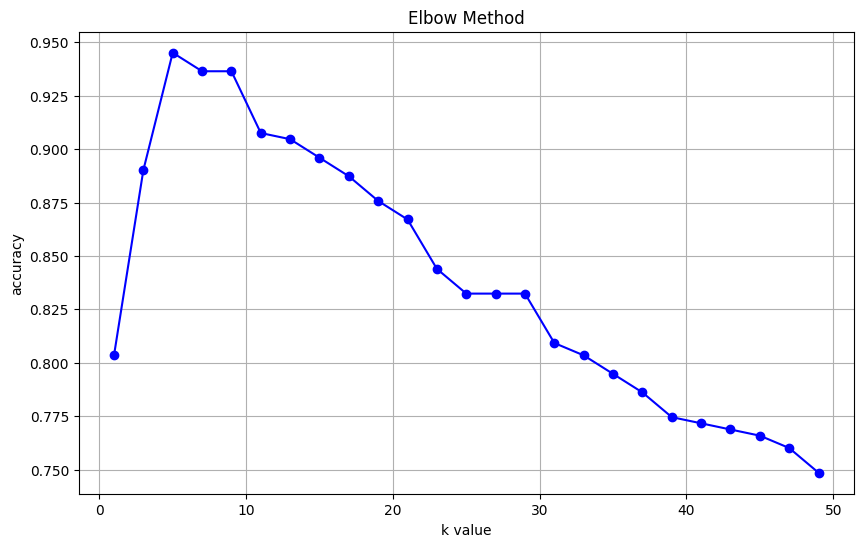

optimal k: 5, accuracy = 0.9451


In [ ]:
import matplotlib.pyplot as plt
k_range = range(1,51,2)
accuracies = []

for k in k_range:
  y_pred_knn = predict_all(X_train,Y_train,X_test,k)
  accuracy = np.sum(Y_test.values == y_pred_knn) / len(Y_test)
  accuracies.append(accuracy)
  print(f"k = {k} accuracy = {accuracy:.4f}")

plt.figure(figsize=(10,6))
plt.plot(k_range,accuracies,"bo-")
plt.xlabel("k value")
plt.ylabel("accuracy")
plt.title("Elbow Method")
plt.grid(True)
plt.show()

optimal_k = k_range[np.argmax(accuracies)]
print(f"optimal k: {optimal_k}, accuracy = {max(accuracies):.4f}")

sklearn naive bayes and kNN

In [ ]:
#naive bayes
from sklearn.naive_bayes import CategoricalNB
nb_sklearn = CategoricalNB()
nb_sklearn.fit(X_train,Y_train)
y_pred_sklearn = nb_sklearn.predict(X_test)

#metrics for sklearn NB
_,metrics_sklearn = calculate_metrics(Y_test.values, y_pred_sklearn)
print("\nSklearn Naive bayes metrics")
for key,val in metrics_sklearn.items():
  print(f"{key} : {val:.4f} ")


  #custom metrics
print("\n cutom metrics")
for key,val in metrics_test.items():
  print(f"{key} : {val:.4f} ")


Sklearn Naive bayes metrics
Accuracy : 0.8642 
Sensitivity (avg) : 0.6386 
Specificity (avg) : 0.9290 
Precision (avg) : 0.8042 
Recall (avg) : 0.6386 
F1 Score (avg) : 0.6929 

 cutom metrics
Accuracy : 0.8642 
Sensitivity (avg) : 0.6386 
Specificity (avg) : 0.9290 
Precision (avg) : 0.8042 
Recall (avg) : 0.6386 
F1 Score (avg) : 0.6929 


KNN comparision

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_sklearn = KNeighborsClassifier(n_neighbors=5, metric='euclidean',
    weights='uniform',
    algorithm='brute')
knn_sklearn.fit(X_train, Y_train)
y_pred_knn_sklearn = knn_sklearn.predict(X_test)

_, metrics_knn_sklearn = calculate_metrics(Y_test.values, y_pred_knn_sklearn)
print("\nSklearn Metrics:")
for key, val in metrics_knn_sklearn.items():
    print(f"  {key}: {val:.4f}")

y_pred_knn_custom = predict_all(X_train, Y_train, X_test, 5)
_, metrics_knn_custom = calculate_metrics(Y_test.values, y_pred_knn_custom)
print("\nCustom Implementation Metrics:")
for key, val in metrics_knn_custom.items():
    print(f"  {key}: {val:.4f}")



K-NN - Sklearn vs Custom (k=5):

Sklearn Metrics:
  Accuracy: 0.9422
  Sensitivity (avg): 0.7719
  Specificity (avg): 0.9713
  Precision (avg): 0.9286
  Recall (avg): 0.7719
  F1 Score (avg): 0.8299

Custom Implementation Metrics:
  Accuracy: 0.9451
  Sensitivity (avg): 0.7752
  Specificity (avg): 0.9737
  Precision (avg): 0.9300
  Recall (avg): 0.7752
  F1 Score (avg): 0.8322
